##SETUP

In [3]:
import os
import sys
import time
import pandas as pd
import numpy as np
# Android ADB
from scrcpy import Client, const

# Image processing
from PIL import Image
import cv2
import pytesseract
# Notebook
from IPython.display import display,clear_output
from tqdm.notebook import trange, tqdm
# internal
sys.path.append('./src')
import bot_core
import bot_perception

import importlib
importlib.reload(bot_core)
importlib.reload(bot_perception)

bot = bot_core.Bot()

# Convert to unit icon 
def crop_img(input, x, y, dx, dy, name='icon.png'):
    # Load screen
    img_rgb = cv2.imread(input)
    img_rgb = img_rgb[y:y + dy, x:x + dx]
    # Convert to grayscale (done internally by tessarct )
    #img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #(a, img_gray) = cv2.threshold(img_rgb, 127, 255, cv2.THRESH_BINARY)
    cv2.imwrite(name, img_rgb)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))


# Evaluate grid to update OCR images
names=bot.scan_grid()
grid_df=bot_perception.grid_status(names)
display(grid_df)

,grid_pos,unit,probability,rank,rank_prob,Age
0,"[0, 0]",monkey.png,312.0,3,1.000000,0.0
1,"[0, 1]",bruser.png,472.0,1,1.000000,0.0
2,"[0, 2]",empty.png,999.0,0,1.000000,0.0
3,"[0, 3]",bruser.png,557.0,3,1.000000,0.0
4,"[0, 4]",crystal.png,227.0,3,1.000000,0.0
5,"[1, 0]",crystal.png,220.0,3,1.000000,0.0
6,"[1, 1]",crystal.png,159.0,1,0.999996,0.0
7,"[1, 2]",chemist.png,644.0,1,0.999999,0.0
8,"[1, 3]",empty.png,700.0,0,1.000000,0.0
9,"[1, 4]",monkey.png,371.0,1,1.000000,0.0


In [13]:
# Check if alive
bot.client.control.text("test")


b'\x01\x00\x00\x00\x04test'

## Look for icons

In [3]:
bot.getScreen()
names=bot.scan_grid()

In [81]:
bot.restart_RR(quick_disconnect=True)

# Add icon

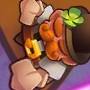

In [4]:
# Add unit
name = 'bruser.png'
#crop_img('OCR_inputs/icon_14.png',17,15,90,90,name)
crop_img('icon_3.png',17,15,90,90,name)

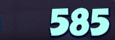

585

In [36]:
# Add button
name = 'home_screen.png'
crop_img('emulator-5554-screenshot.png',30,1020,70,70,name)


In [51]:
bot.get_current_icons(new=False,available=True)

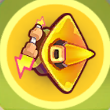

In [12]:
# Add rank
name = 'rank1.png'
crop_img('OCR_inputs/icon_8.png',5,5,110,110,name)

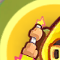

In [60]:
# Add rank
name = 'rank1.png'
crop_img('OCR_inputs/icon_8.png',5,5,60,60,name)

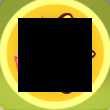

In [8]:
# cuts out middle pixels from unit icon
def crop_rank(input,name=input):
    img_rgb = cv2.imread(input)
    keep=18
    img_rgb[keep:-keep,keep:-keep] = 0
    cv2.imwrite(name, img_rgb)
    #display
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))

crop_rank('rank1.png','rank1_C.png')

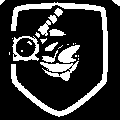

In [34]:
# cuts out middle pixels from unit icon
def image_to_binary(input,name=input):
    img = cv2.imread(input)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keep=30
    #gray[keep:-keep,keep:-keep] = 255
    #thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    thresh = cv2.threshold(gray,180,255,cv2.THRESH_BINARY)[1]
    cv2.imwrite(name, thresh)
    display(Image.fromarray(thresh))
name = 'rank5.png'
image_to_binary('OCR_inputs/icon_11.png',name)

In [103]:
df_split, df_groups, unit_list = bot_core.get_unit_count(grid_df)
df_groups.sort_values(ascending=False)

unit
lightning.png    5
empty.png        3
fire_mage.png    3
archer.png       2
cold_mage.png    2
Name: unit, dtype: int64